#### Compare noise levels: TOAST vs SO-SAT V3 vs early SATP3 data 

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import sys

sys.path.append("/global/homes/k/kwolz/bbdev/SOOPERCOOL")
import soopercool.utils as ut
import soopercool.ps_utils as pu

In [2]:
def load_noise_map(nside, id_sim, noise_dir):
    """ """
    sim_str = str(id_sim).zfill(4)
    map = hp.read_map(noise_dir.replace("[id_sim]", sim_str), field=range(3))
    return hp.ud_grade(map, nside_out=nside)

In [3]:
def compute_workspace(nmt_bin, nside, mask_dir):
    """
    Compute the NaMaster workspace to compute decoupled pseudo-C_ells.
    """
    w = nmt.NmtWorkspace()
    mask = hp.ud_grade(hp.read_map(mask_dir), nside_out=nside)
    f = nmt.NmtField(mask, None, spin=2, purify_b=True)
    w.compute_coupling_matrix(f, f, nmt_bin)

    return w, mask


def read_nmt_binning(path_to_binning):
    """
    Read the binning file and return the corresponding NmtBin object.
    """
    import pymaster as nmt

    binning = np.load(path_to_binning)
    return nmt.NmtBin.from_edges(binning["bin_low"], binning["bin_high"] + 1)


def nmt_bin_from_edges(bin_edges, nside):
    """
    Computes a NaMaster NmtBin object given an input array of bin edges.
    """
    bin_edges = np.array(bin_edges)
    bin_edges = bin_edges[bin_edges < 3 * nside]
    bin_edges = np.concatenate((bin_edges, [3 * nside]))
    return nmt.NmtBin.from_edges(bin_edges[:-1], bin_edges[1:])


def get_decoupled_ps_namaster(map1, map2, mask, nmt_bin, wsp):
    """
    Compute decoupled pseudo C_ells from a map pair given a NaMaster workspace.
    """
    f1 = nmt.NmtField(mask, map1[1:], purify_b=True)
    f2 = nmt.NmtField(mask, map2[1:], purify_b=True)
    pcl = nmt.compute_coupled_cell(f1, f2)
    cl_dict = {
        f: wsp.decouple_cell(pcl)[f_idx]
        for f_idx, f in enumerate(["EE", "EB", "BE", "BB"])
    }
    cl_dict["l"] = nmt_bin.get_effective_ells()

    return cl_dict


def get_decoupled_ps(map1, map2, mask, nmt_bin, coupling_inv):
    """
    Compute decoupled pseudo C_ells from a map pair given a NaMaster workspace.
    """
    nbin = nmt_bin.get_n_bands()
    assert (
        nbin == coupling_inv.shape[-1]
    ), f"nmt_bin has {nbin} ell-bands, while coupling_inv has {coupling_inv.shape[-1]}."
    f1 = nmt.NmtField(mask, map1[1:], purify_b=True)
    f2 = nmt.NmtField(mask, map2[1:], purify_b=True)
    pclb = nmt_bin.bin_cell(nmt.compute_coupled_cell(f1, f2))
    stacked_pclb = np.zeros((9, nbin))
    for i in range(4):
        stacked_pclb[5 + i, :] += pclb[i]
    coupling_inv = coupling_inv.reshape((nbin * 9, nbin * 9))
    stacked_pclb = stacked_pclb.reshape(nbin * 9)
    print("matmul", coupling_inv.shape, stacked_pclb.shape)
    decoupled_pclb_vec = coupling_inv @ stacked_pclb
    decoupled_pclb_vec = decoupled_pclb_vec.reshape(9, nbin)[5:]

    cl_dict = {
        f: decoupled_pclb_vec[f_idx] for f_idx, f in enumerate(["EE", "EB", "BE", "BB"])
    }
    cl_dict["l"] = nmt_bin.get_effective_ells()

    return cl_dict

In [4]:
globals = {
    "Nsims": 10,
    "nside": 512,
    # "bin_edges": [
    #     2, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160,
    #     170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300
    # ],
    "binning": "/pscratch/sd/k/kwolz/bbdev/SOOPERCOOL/output_purify_noiseless/pre_processing/binning.npz",
    "noise_dir": "/global/cfs/projectdirs/sobs/awg_bb/bbmaster_paper/Noise_forpaper/Atm_10m-reso/[id_sim]/filterbin_coadd-full_map.fits",
    "nhits_dir": "/pscratch/sd/k/kwolz/bbdev/SOOPERCOOL/output_purify_noiseless/masks/nhits_map.fits",
    "mask_dir": "/pscratch/sd/k/kwolz/bbdev/SOOPERCOOL/output_purify_noiseless/masks/analysis_mask.fits",
}

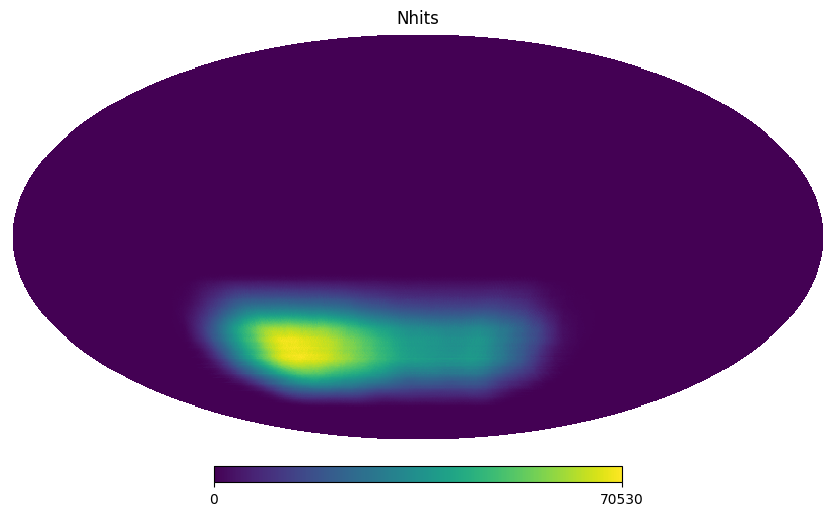

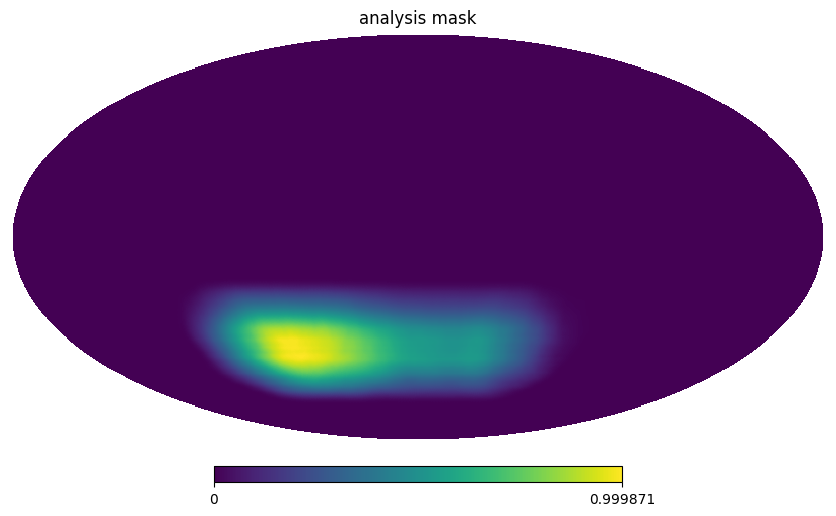

In [5]:
nhits = hp.read_map(globals["nhits_dir"])
hp.mollview(nhits, title="Nhits")

fsky = sum(nhits) / max(nhits) / len(nhits)
noise_dir = globals["noise_dir"]
# bin_edges = globals["bin_edges"]
binning_file = globals["binning"]
Nsims = globals["Nsims"]
nside = globals["nside"]
mask_dir = globals["mask_dir"]
npix = hp.nside2npix(nside)
# nmt_bin = nmt_bin_from_edges(bin_edges, nside)
nmt_bin = read_nmt_binning(binning_file)
lb = nmt_bin.get_effective_ells()
wsp, mask = compute_workspace(nmt_bin, nside, mask_dir)
hp.mollview(mask, title="analysis mask")

In [6]:
noise_sims = np.zeros((Nsims, 3, npix))

for id_sim in range(Nsims):
    print(id_sim)
    noise_sims[id_sim] += load_noise_map(nside, id_sim, noise_dir)

0


1
2
3
4
5
6
7
8
9


In [7]:
couplings_file = "/pscratch/sd/k/kwolz/bbdev/SOOPERCOOL/output_purify_noiseless/couplings/couplings_nonexnone_filtered.npz"
coupling_inv = np.load(couplings_file)["inv_coupling"]
print("coupling_inv", coupling_inv.shape)
print("bpwin", np.load(couplings_file)["bp_win"].shape)

coupling_inv (9, 154, 9, 154)
bpwin (9, 154, 9, 1536)


In [8]:
nl_toast_bb = []
nl_toast_ee = []

for id_sim in range(Nsims):
    print(id_sim)
    # nl = get_decoupled_ps_namaster(
    #     noise_sims[id_sim], noise_sims[id_sim], mask, nmt_bin, wsp
    # )
    nl = get_decoupled_ps(
        noise_sims[id_sim], noise_sims[id_sim], mask, nmt_bin, coupling_inv
    )
    print(nl["BB"].shape)
    # nl = pu.decouple_pseudo_cls(coupled_pseudo_cells, coupling_inv)
    nl_toast_bb += [nl["BB"]]
    nl_toast_ee += [nl["EE"]]
nl_toast_bb_mean = np.mean(np.array(nl_toast_bb), axis=0)
nl_toast_bb_std = np.std(np.array(nl_toast_bb), axis=0)
nl_toast_ee_mean = np.mean(np.array(nl_toast_ee), axis=0)
nl_toast_ee_std = np.std(np.array(nl_toast_ee), axis=0)

0
matmul (1386, 1386) (1386,)
(154,)
1


In [ ]:
import sys

sys.path.append("/global/homes/k/kwolz/bbdev/SOOPERCOOL")
import soopercool.utils as ut

survey_years = 1.0
N_instr = 2

nl_adrien_filtered = ut.get_noise_spectrum_adrien(
    np.arange(3 * nside), N_yr=survey_years, N_instr=2, fsky=fsky, filtered=True
)
nl_adrien_unfiltered = ut.get_noise_spectrum_adrien(
    np.arange(3 * nside), N_yr=survey_years, N_instr=2, fsky=fsky, filtered=False
)
nl_goal_opt = ut.get_noise_spectrum(
    np.arange(3 * nside),
    fsky_eff=fsky,
    has_oof=True,
    N_tubes=[0.0, N_instr, 1.0],
    survey_years=1.0,
    freq_ghz=93,
)
nl_baseline_pess = ut.get_noise_spectrum(
    np.arange(3 * nside),
    fsky_eff=fsky,
    has_oof=True,
    N_tubes=[0.0, N_instr, 1.0],
    survey_years=1.0,
    freq_ghz=93,
    sensitivity="baseline",
    oof_mode="pessimistic",
)

/global/homes/k/kwolz/bbdev/SOOPERCOOL/soopercool/SO_Noise_Calculator_Public_v3_1_2.py:228: RuntimeWarning: invalid value encountered in double_scalars
  tube_count * N_tels /
/global/homes/k/kwolz/bbdev/SOOPERCOOL/soopercool/SO_Noise_Calculator_Public_v3_1_2.py:228: RuntimeWarning: divide by zero encountered in double_scalars
  tube_count * N_tels /


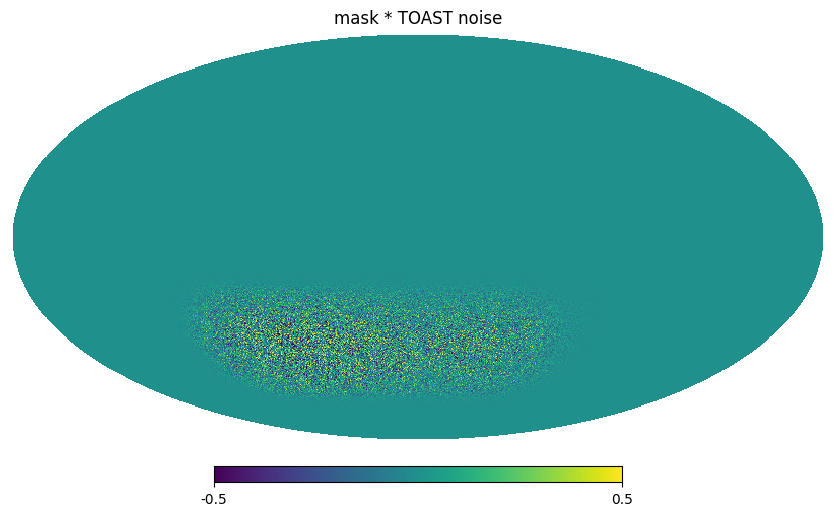

<Figure size 640x480 with 0 Axes>

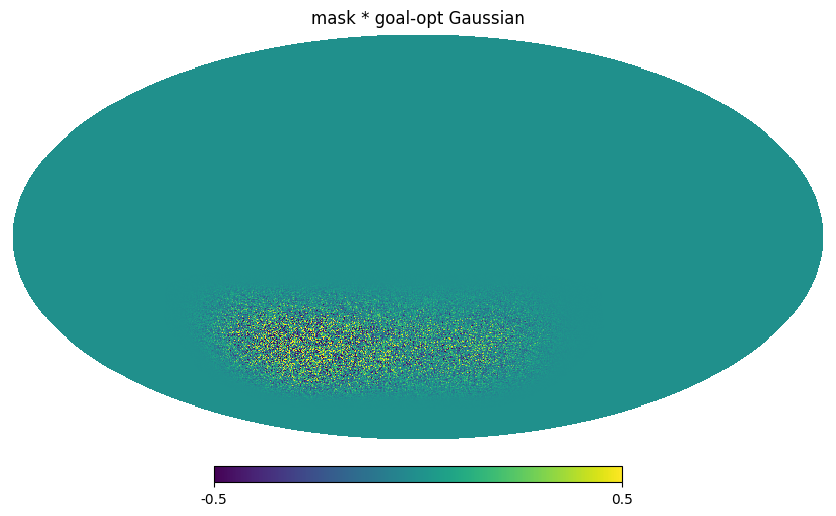

In [ ]:
hp.mollview(
    mask * 1.0e6 * noise_sims[0, 1], min=-0.5, max=0.5, title="mask * TOAST noise"
)
plt.show()
plt.clf()
nl_goal_opt_arr = [nl_goal_opt[k] for k in ["TT", "EE", "BB", "TE"]]
hp.mollview(
    mask * hp.synfast(nl_goal_opt_arr, nside=nside)[1],
    title="mask * goal-opt Gaussian",
    min=-0.5,
    max=0.5,
)
plt.show()

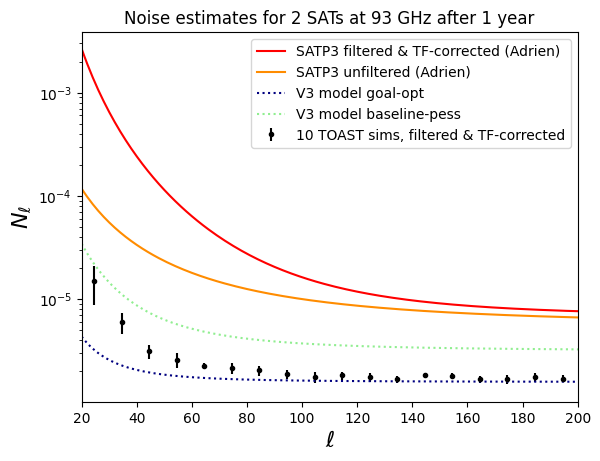

In [ ]:
msk = np.logical_and(lb <= 600, lb >= 20)
ls = np.arange(3 * nside)
mnl = np.logical_and(ls <= 600, ls >= 20)

plt.errorbar(
    lb[msk],
    1.0e12 * nl_toast_bb_mean[msk],
    1.0e12 * nl_toast_bb_std[msk],
    c="k",
    ls="",
    marker=".",
    label=f"{Nsims} TOAST sims, filtered & TF-corrected",
)
plt.plot(
    ls[mnl],
    nl_adrien_filtered["BB"][mnl],
    "r-",
    label="SATP3 filtered & TF-corrected (Adrien)",
)
plt.plot(
    ls[mnl],
    nl_adrien_unfiltered["BB"][mnl],
    c="darkorange",
    ls="-",
    label="SATP3 unfiltered (Adrien)",
)
plt.plot(ls[mnl], nl_goal_opt["BB"][mnl], c="navy", ls=":", label="V3 model goal-opt")
plt.plot(
    ls[mnl],
    nl_baseline_pess["BB"][mnl],
    c="lightgreen",
    ls=":",
    label="V3 model baseline-pess",
)
plt.yscale("log")
# plt.xscale("log")
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r"$N_\ell$", fontsize=16)
plt.xlim((20, 200))
plt.title("Noise estimates for 2 SATs at 93 GHz after 1 year", fontsize=12)
plt.legend()

In [ ]:
ratio_toast_blpe = [
    1.0e12 * nl_toast_bb_mean[mnl][ib] / nl_baseline_pess["BB"][int(lb[msk][ib])]
    for ib in range(len(lb[msk]))
]
plt.axhline(0, color="k")
plt.axhline(1, color="k")
# mask = lb < 300
plt.plot(lb[msk], ratio_toast_blpe, "b-", label="Ratio TOAST / V3 noise")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 154 but corresponding boolean dimension is 1536